## Лабораторная работа №2 

## Фильтрация изображений

Вариант: №3

Выполнил: Новицкий Никита

Группа: 6132-010402D

1. Считать цветное rgb изображение
2. Зашумить изображение аддитивным шумом с вероятностью p (по вариантам).
  *   Вход: изображение из пункта 1
  *   Вывод: зашумленное изображение
3. Написать функцию реализации ранговой фильтрации

> Функцию вида fun(Image, window, rank)  
Где window  - окно фильтрации (по вариантам)  
rank - опциональный параметр, значение ранга в ранговой фильтрации


4. Отфильтровать зашумленное изображение со всеми возможными рангами (кол-во рангов зависит от окна по вариантам).  
Подсчитать СКО для результата фильтрации с каждым рангом.
  *   Вход: изображение из пункта 2
  *   Вывод: Значения СКО для каждого ранга. Исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованные изображения для первого, последнего ранга, а так же для ранга с наименьшим СКО.
  *   СКО считать между отфильтрованным изображением и исходным (не зашумленным) из пункта 1
5. Написать функцию реализации свертки

> Функцию вида fun(mat1, mat2)  
Где mat1  - первый сигнал. В данном случае изображение  
mat2 - второй сигнал. В данном ядро КИХ фильтра

6. Отфильтровать изображение КИХ фильтром с ядром заданным по вариантам. Подсчитать СКО. Сравнить с результатами пункта 4.
  *   Вход: изображение из пункта 2
  *   Вывод: Значения СКО . Исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованное изображение.
  *   СКО считать между отфильтрованным изображением и исходным (не зашумленным) из пункта 1

  
    
    
*Для работы с изображением использовать OpenCV (открытие, сохранение и т.д.). Для визуализации можно использовать matplotlib. Все необходимые для задания функции реализовавать самим, а не использовать готовые в OpenCV, если не указано обратного. С изображениями работать с цветными по каждому из каналов.*

№ варианта | Вероятность p | Вид окна ранговой фильтрации | Ядро КИХ фильтра 
--- | :---: | :---: | :---:
3 | 0,11 | $ \left(\begin{array}{ccccc} 
0 & 0 & 1 & 0 & 0\\
0 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
0 & 1 & 1 & 1 & 0\\
0 & 0 & 1 & 0 & 0
\end{array}\right)$  | $ \frac 1{13} \left(\begin{array}{ccc} 
1 & 2 & 1\\
2 & 1 & 2\\
1 & 2 & 1
\end{array}\right)$

In [1]:
from itertools import product
from warnings import filterwarnings

import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.pyplot import *
from tqdm.notebook import tqdm

filterwarnings("ignore")
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10)

In [2]:
print(f'Версия matplotlib: {matplotlib.__version__}')
print(f'Версия numpy: {np.__version__}')
print(f'Версия opencv: {cv2.__version__}')

Версия matplotlib: 3.5.1
Версия numpy: 1.21.5
Версия opencv: 4.5.5


In [3]:
# Вероятность p
PROBABILITY = 0.11

# Окно ранговой фильтрации
KERNEL = np.array([
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0]
])

# Ядро КИХ фильтра
FIR_KERNEL = (1/13) * np.array([
    [1, 2, 1], 
    [2, 1, 2], 
    [1, 2, 1]
])

# Задание 1. 
Считать цветное RGB изображение

In [4]:
def show_image(image):
    """Функция для вывода изображения."""
    plt.axis('off')
    plt.imshow(image)

Исходное изображение:


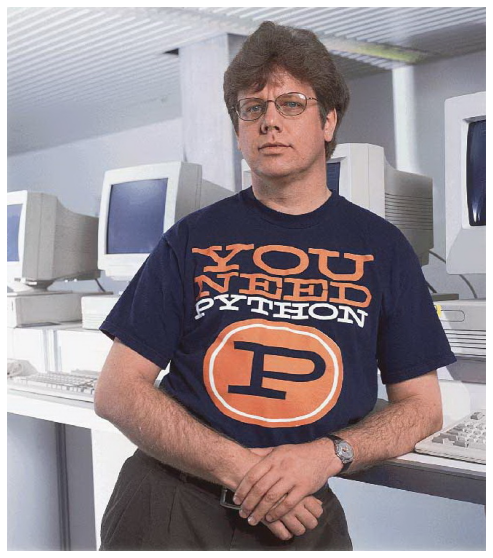

In [5]:
image = cv2.cvtColor(cv2.imread('../images/guido.jpeg'), cv2.COLOR_BGR2RGB)
print('Исходное изображение:')
show_image(image)

# Задание 2. 

Зашумить изображение аддитивным шумом с вероятностью p (по вариантам).
  *   Вход: изображение из пункта 1
  *   Вывод: зашумленное изображение

In [6]:
def add_noise(image, probability):
    """Функция для нанесения шума на изображения с заданной вероятностью p."""
    image_rows, image_cols, image_channels = image.shape
    output_image = np.copy(image)
    pixels = []

    for pixel in list(product(range(image_rows), range(image_cols))):
        if np.random.random() <= probability:
            pixels.append(pixel)

    for pixel in tqdm(pixels):
        for image_channel in range(image_channels):
            if output_image[pixel[0], pixel[1]][image_channel] + 50 > 255:
                output_image[pixel[0], pixel[1]][image_channel] = 255
            else:
                output_image[pixel[0], pixel[1]][image_channel] += 50

    clear_output()
    return output_image

Исходное изображение:


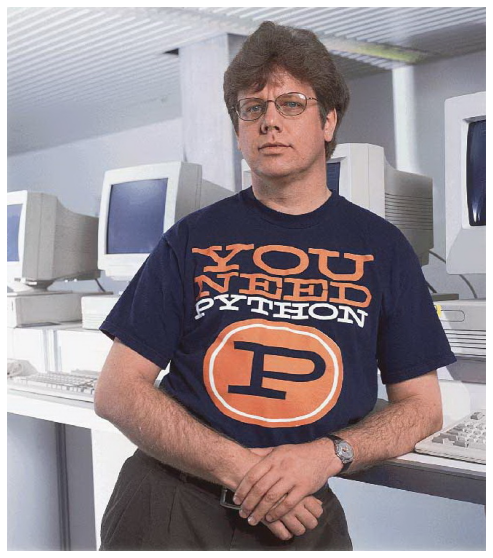

In [7]:
print('Исходное изображение:')
show_image(image)

Зашумленное изображение:


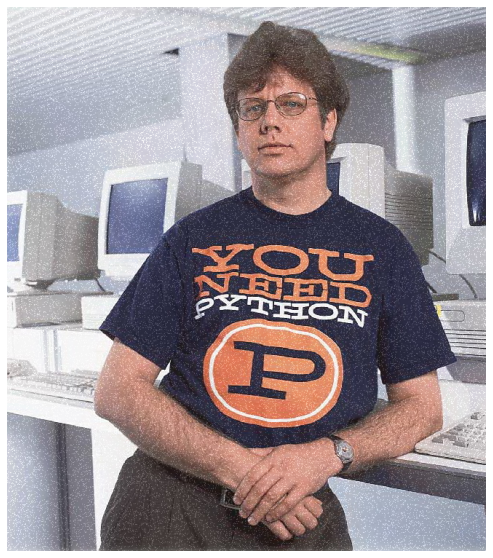

In [8]:
image_noise = add_noise(image, PROBABILITY)
print('Зашумленное изображение:')
show_image(image_noise)

# Задание 3. 

Написать функцию реализации ранговой фильтрации

> Функцию вида fun(Image, window, rank)  
Где window  - окно фильтрации (по вариантам)  
rank - опциональный параметр, значение ранга в ранговой фильтрации

In [9]:
def get_value(image, kernel, rank):
    """Вспомогательная функция для получения значения."""
    image_rows, image_cols, image_channels = image.shape
    output_image = np.zeros((image_channels,))

    for image_channel in range(image_channels):
        vals = []
        for i in range(image_rows):
            for j in range(image_cols):
                for _ in range(kernel[i, j]):
                    vals.append(image[i, j, image_channel])

        output_image[image_channel] = np.sort(vals, axis=0)[rank]

    return output_image

In [10]:
def rank_filtering(image, kernel, rank):
    """Функция ранговой фильтрации."""
    image_rows, image_cols, image_channels = image.shape
    kernel_cols, kernel_rows = kernel.shape[0] // 2, kernel.shape[1] // 2
    output_image = np.zeros(
        (image_rows, image_cols, image_channels), dtype=np.uint8)

    for i in tqdm(range(kernel_rows, image_rows - kernel_rows)):
        for j in range(kernel_cols, image_cols - kernel_cols):
            current_window = image[
                i - kernel_rows: i + kernel_rows + 1,
                j - kernel_cols: j + kernel_cols + 1,
            ]
            output_image[i, j] = get_value(current_window, kernel, rank)

    clear_output()
    return output_image

Исходное изображение:


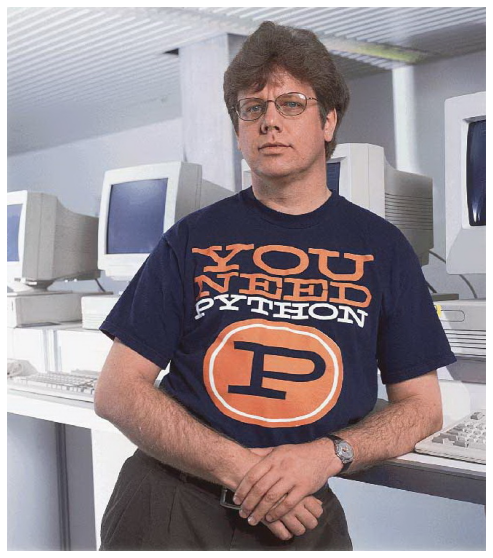

In [11]:
print("Исходное изображение:")
show_image(image)

Зашумленное изображение:


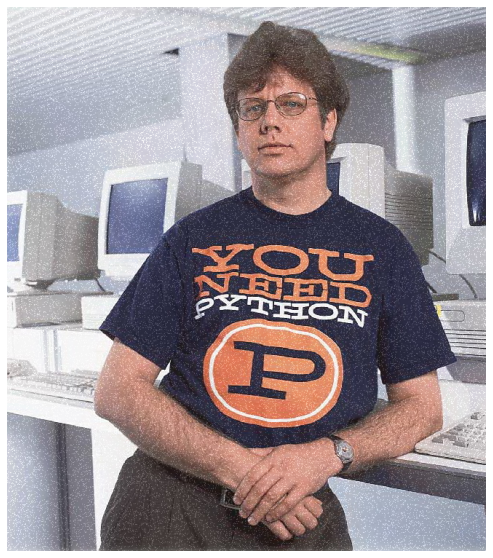

In [12]:
print('Зашумленное изображение:')
show_image(image_noise)

Отфильтрованное изображение:


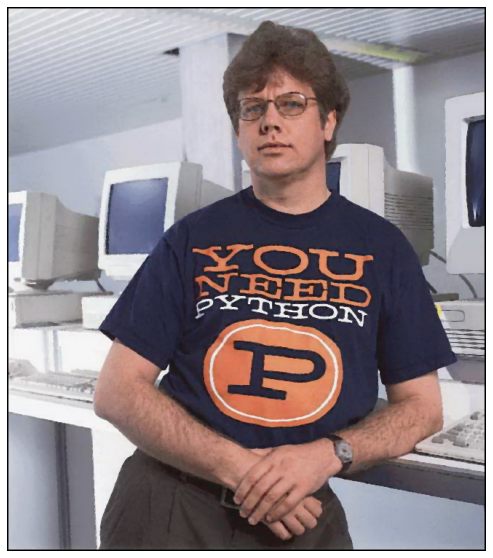

In [13]:
filtering_image = rank_filtering(image_noise, KERNEL, 3)
print('Отфильтрованное изображение:')
show_image(filtering_image)

# Задание 4. 

Отфильтровать зашумленное изображение со всеми возможными рангами (кол-во рангов зависит от окна по вариантам).  
Подсчитать СКО для результата фильтрации с каждым рангом.
  *   Вход: изображение из пункта 2
  *   Вывод: Значения СКО для каждого ранга. Исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованные изображения для первого, последнего ранга, а так же для ранга с наименьшим СКО.
  *   СКО считать между отфильтрованным изображением и исходным (не зашумленным) из пункта 1

In [14]:
def calculating_mse(image, image_noise):
    """Функция для подсчета СКО."""
    return np.sum((image - image_noise) ** 2) / (
        image.shape[0] * image.shape[1] * image.shape[2]
    )

In [15]:
results = []

for rank in tqdm(range(1, np.sum(KERNEL.flatten()))):
    mse = calculating_mse(image, rank_filtering(image_noise, KERNEL, rank))
    results.append((rank, mse))
    clear_output()
    print(f'Rank: {rank}, MSE: {mse}')

sorted_results = sorted(results, key=lambda x: x[1])

Rank: 12, MSE: 109.08480731436384


In [16]:
sorted_results

[(5, 21.311563715178174),
 (6, 21.875714950311206),
 (4, 23.689328743545612),
 (7, 26.349301291623775),
 (3, 28.97712430268185),
 (8, 32.699921604689614),
 (2, 35.19945842132461),
 (9, 42.19778472213745),
 (1, 43.02114774532103),
 (10, 57.4088186586264),
 (11, 81.84456502131458),
 (12, 109.08480731436384)]

Исходное изображение:
MSE: 0.0


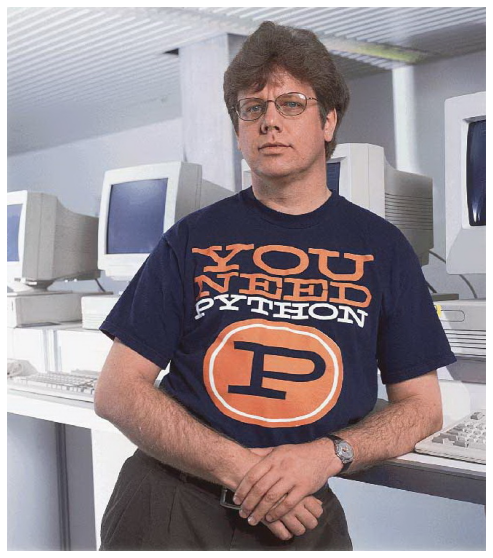

In [17]:
print('Исходное изображение:')
print(f'MSE: {calculating_mse(image, image)}')
show_image(image)

Зашумленное изображение:
MSE: 19.638151389753542


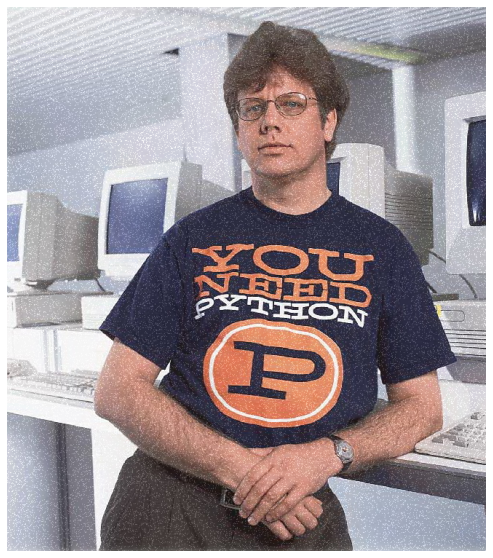

In [18]:
print('Зашумленное изображение:')
print(f'MSE: {calculating_mse(image, image_noise)}')
show_image(image_noise)

Rank: 1
MSE first rank: 43.02114774532103


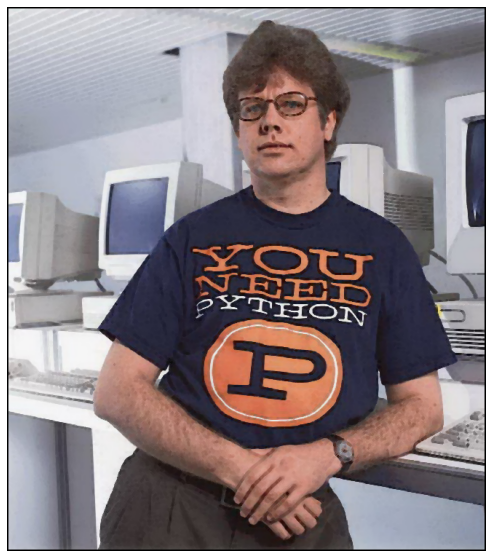

In [19]:
first_rank_image = rank_filtering(image_noise, KERNEL, 1)
print(f'Rank: {1}')
print(f'MSE first rank: {calculating_mse(image, first_rank_image)}')
show_image(first_rank_image)

Rank: 12
MSE last rank: 109.08480731436384


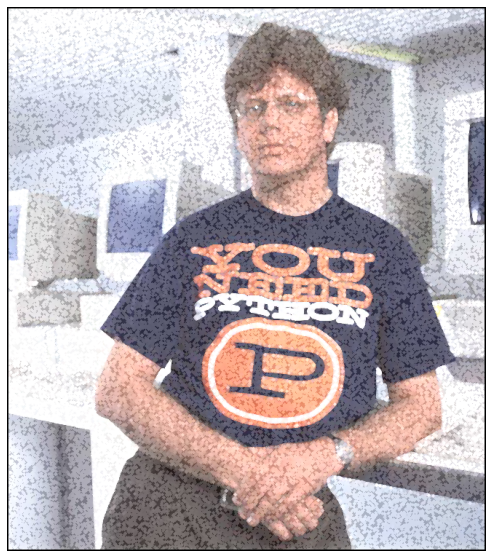

In [20]:
last_rank_image = rank_filtering(image_noise, KERNEL, 12)
print(f'Rank: {12}')
print(f'MSE last rank: {calculating_mse(image, last_rank_image)}')
show_image(last_rank_image)

Best rank: 5
MSE best rank: 21.311563715178174


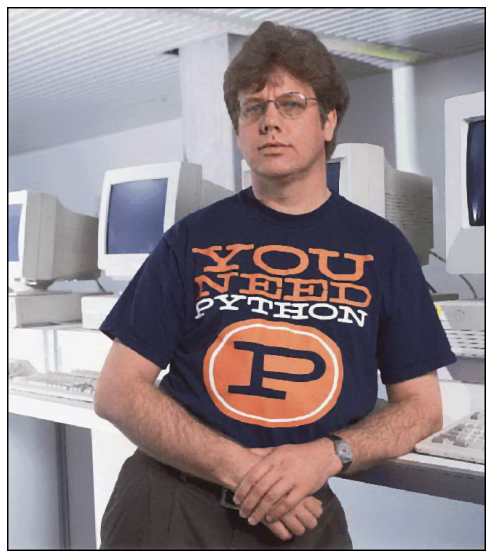

In [21]:
best_filtering_image = rank_filtering(
    image_noise, KERNEL, sorted_results[0][0])
print(f'Best rank: {sorted_results[0][0]}')
print(f'MSE best rank: {calculating_mse(image, best_filtering_image)}')
show_image(best_filtering_image)

# Задание 5. 

Написать функцию реализации свертки

> Функцию вида fun(mat1, mat2)  
Где mat1  - первый сигнал. В данном случае изображение  
mat2 - второй сигнал. В данном ядро КИХ фильтра

In [22]:
def convolution(image, kernel):
    """Функция свертки."""
    __kernel = np.flipud(np.fliplr(kernel))
    image_rows, image_cols, image_channels = image.shape
    kernel_rows, kernel_cols = kernel.shape
    output_image = np.zeros_like(image)

    if kernel_rows % 2 == 0:
        output_image_rows = image_rows + (kernel_rows // 2)
        copy_rows = (0, image_rows)
    else:
        output_image_rows = image_rows + 2 * (kernel_rows // 2)
        copy_rows = (kernel_rows // 2, output_image_rows - (kernel_rows // 2))

    if kernel_cols % 2 == 0:
        output_image_cols = image_cols + (kernel_cols // 2)
        copy_cols = (0, image_cols)
    else:
        output_image_cols = image_cols + 2 * (kernel_cols // 2)
        copy_cols = (kernel_cols // 2, output_image_cols - (kernel_cols // 2))

    img = np.zeros((output_image_rows, output_image_cols, image_channels))
    img[copy_rows[0]: copy_rows[1], copy_rows[0]: copy_cols[1], :] = image

    for i, j, k in tqdm(np.ndindex((image_rows, image_cols, image_channels))):
        output_image[i, j, k] = np.sum(
            __kernel * img[i: i + kernel_rows, j: j + kernel_cols, k]
        )

    clear_output()
    return output_image

# Задание 6. 

Отфильтровать изображение КИХ фильтром с ядром заданным по вариантам. Подсчитать СКО. Сравнить с результатами пункта 4.
  *   Вход: изображение из пункта 2
  *   Вывод: Значения СКО . Исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованное изображение.
  *   СКО считать между отфильтрованным изображением и исходным (не зашумленным) из пункта 1

Исходное изображение:
MSE: 0.0


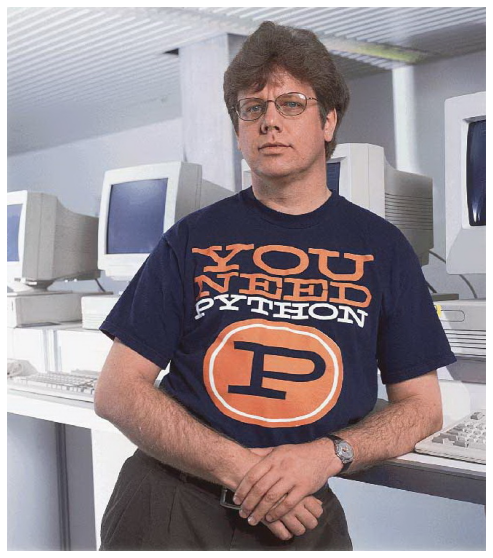

In [23]:
print('Исходное изображение:')
print(f'MSE: {calculating_mse(image, image)}')
show_image(image)

Зашумленное изображение:
MSE: 19.638151389753542


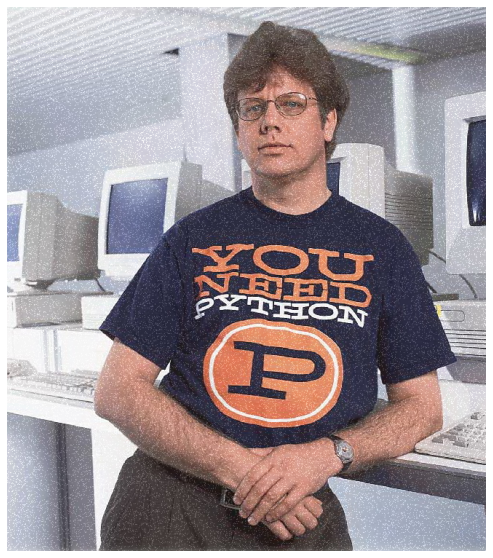

In [24]:
print('Зашумленное изображение:')
print(f'MSE: {calculating_mse(image, image_noise)}')
show_image(image_noise)

Изображение после КИХ-фильтра
FIR:
[[0.07692308 0.15384615 0.07692308]
 [0.15384615 0.07692308 0.15384615]
 [0.07692308 0.15384615 0.07692308]]
MSE: 49.72049833918585


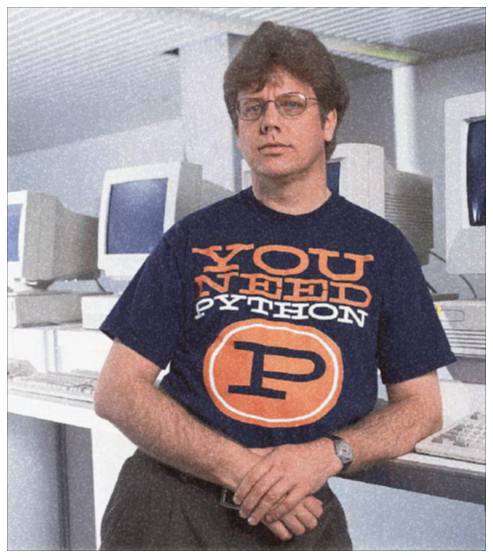

In [25]:
image_fir_filter = convolution(image_noise, FIR_KERNEL)
print('Изображение после КИХ-фильтра')
print(f'FIR:\n{FIR_KERNEL}')
print(f'MSE: {calculating_mse(image, image_fir_filter)}')
show_image(image_fir_filter)

# Выводы.

Ранговая фильтрация с рангом $5$ справилась с фильтрацией намного лучше, чем фильтрация с КИХ фильтром $ \frac 1{13} \left(\begin{array}{ccc} 
1 & 2 & 1\\
2 & 1 & 2\\
1 & 2 & 1
\end{array}\right)$